<a href="https://colab.research.google.com/github/HannahMwende/Driver-Drowniness-detection-system/blob/main/driver_drowniness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver drowniness detection system




#### Authors
* Ann Maureen
* Hannah Mutua
* Ibrahim Hafiz
* Samuel Kabati
* Angela Cheruto
* Janet Gachoki

## 1. Business understanding

###1.1 Introduction
Drowsy Driving is the act of driving while feeling fatigued or sleepy. There are various factors that can contribute to drowsy driving. Sleep depletion, sleep disorders, medication, stress, drunk driving, or extended hours for shift work are some of the factors. Drowsy driving can have a number of effects on the driver such as poor judgment, loss of attention, and delayed reaction times.<br>

A report by the National Security Council (NSC) shows that in the United States, drowsy driving accounts for about 100,000 crashes, 71000 injuries, and 1550 fatalities annually. Another report by American Automobile Association (AAA) shows that 9.5% of car crashes are caused by drowsy driving and 27% of drivers admit that they have a difficult time keeping their eyes open while driving if they are tired.<br>

In Kenya, a report by the  National Transport and Safety Authority shows that the number of people killed and injured in road crashes went up by 17.5% in September 2021 as compared to the same period in 2020. Falling asleep at the wheel is one of the major causes of these accidents. Research has indicated that going more than 20 hours without sleep is the equivalent of having a blood-alcohol concentration of 0.08%.


###1.2 Problem statement
Dereva car brand company is looking to manufacture innovative and outstanding quality vehicles with a special emphasis on the safety features of their cars in order to reduce the rising number of accidents resulting from drowsy drivers.<br>
Our project will major in curbing the high rate of accidents by developing a  driver drowsiness detection system built on a neural network that can determine if eyes are open or closed and, when used in conjunction with computer vision, can determine whether a living human has had their eyes closed for longer than three seconds 
 


###1.3 Main objective
To develop a neural network that can detect if eyes are open or closed.




###1.4 Specific Objectives
* Determine the region of interest which is the eye region
* Deploy our model to a webcam application that will classify a driver as having slept on the wheel if the positive class(eyes closed) is true for more than three frames.

###1.5 Metric of success
Our model will be considered successful if an AUC score of 0.97 will be attained .

###1.6 Understanding the problem context
For drowsiness detection, our goal is to correctly detect whether one has their eyes open or closed. If the eyes remain closed for more than three seconds the driver should receive an alert to wake them up.According to the following [article](<https://www.webmd.com/sleep-disorders/what-to-know-microsleep>) by WebMD if you doze off for 3 seconds while at a speed of 27 metres per second you can travel 92 metres in the wrong direction. 
Using the Area Under the curve (AUC) as our metric we are looking at the probability that our model will rank a true positive higher than a false positive.
With an AUC score of 0.97, our model is able to correctly separate the open eyes and the closed eyes 97 times out of 100.  

###1.7 Defining Experimental design
* Import the relevant libraries used in the analysis.

* Load and preview images

* Explore the dataset we will use for our project.

* Exploratory Data Analysis (EDA)

* Data Pre-processing

* Modelling and Evaluation

* Challenging the model

* Conclusion

* Recommendations

##2. Data understanding
The data is from [Kaggle](<https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset>) it was created with the help of a larger-scale dataset of human eyes from Media Research Lab.

The dataset contains images of the eye state whether open or closed. Of the 4000 images, 2000 are open eyes, and 2000 are closed eyes some with glasses some without. The images have a bit depth of 8. The dataset contains images with high and low resolution since they were captured by different devices under different lighting conditions.

##3. Loading the data

###3.1 Importing libraries

In [1]:
#Importing libraries

import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, accuracy_score, auc, plot_roc_curve, roc_auc_score,recall_score, precision_score, f1_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from PIL import Image as im
import seaborn as sns
import tensorflow as tf
tf.random.set_seed(2)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


###3.2 Loading data

In [2]:
#Connecting colab to gooogle drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 #Printing contents of train folder
print(os.listdir("/content/drive/Shareddrives/Elite Drive/train"))

['Open_Eyes', 'Closed_Eyes']


The os.listdir()  gets the list of all files and directories in the specified directory.  .

In [4]:
#Loading images from the folders and labelling them
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images



folder="/content/drive/Shareddrives/Elite Drive/train/Open_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/Shareddrives/Elite Drive/train/Closed_Eyes"
closed_eyes=load_images_from_folder(folder,1)

##4. Previewing data

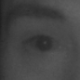

In [5]:
#Displaying an image from open eyes
data=im.fromarray(open_eyes[0][0])
data

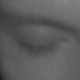

In [6]:
#Dispaying an image from closed eyes
data=im.fromarray(closed_eyes[119][0])
data

##5. Data Exploration
For better understanding of our data we will plot some visualizations.

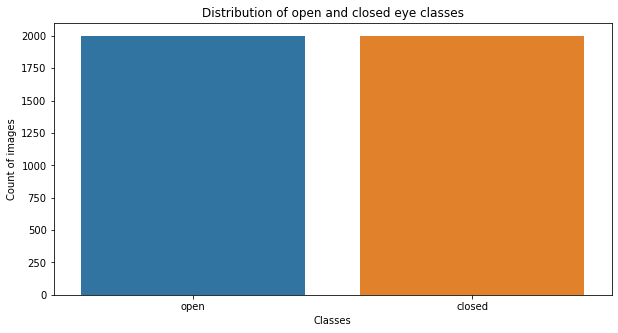

The total number of images of the Opened eyes: 2000
The total number of images of the Closed eyes: 2000


In [7]:
#Visualization of open and closed eyes
open=len(open_eyes)
closed=len(closed_eyes)
data={
    'open':open,
    'closed':closed,
}
classes=list(data.keys())
values=list(data.values())
plt.figure(figsize=(10,5))
sns.barplot(x=classes,y=values)
plt.xlabel("Classes")
plt.ylabel("Count of images")
plt.title('Distribution of open and closed eye classes')
plt.show()


print("The total number of images of the Opened eyes:", len(open_eyes))
print("The total number of images of the Closed eyes:", len(closed_eyes))


As seen ,the classes represented by our data (open and closed eyes) are balanced.

##6.Image Pre-processing

###6.1 Data split

In [8]:
#Combining the dataset
eyes=open_eyes+closed_eyes


#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)

###6.2 Reshaping and normalization
Reshaping is done to ensure images are of a fixed size before they are fed into the networks.<BR>

On the other hand, normalization reduces the pixel values to a range between 0 and 1 as  pixel values can range from 0 to 256. Each number represents a color code.
When using the image as it is and passing through a Deep Neural Network, the computation of high numeric values may become more complex.<br>
In this way, the numbers will be small and the computation becomes easier and faster this is achieved by dividing all the values by 255.


In [9]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

###6.3 Train test split

In [10]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )
print(f"Shape for X_train : {X_train.shape}")
print(f"Shape for X_test :{X_test.shape}")
print(f"Shape for y_train :{y_train.shape}")
print(f"Shape for y_test :{y_test.shape}")


Shape for X_train : (3000, 80, 80, 3)
Shape for X_test :(1000, 80, 80, 3)
Shape for y_train :(3000,)
Shape for y_test :(1000,)


Label: 1


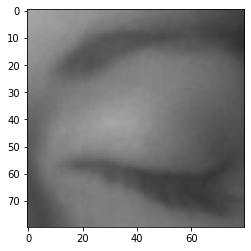

In [11]:
#Taking a quick look at a random image and its corresponding label
sample_image = X_train[10]
sample_label =y_train[10]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

In [12]:
#class names for images shown below 

class_names=['open','close']

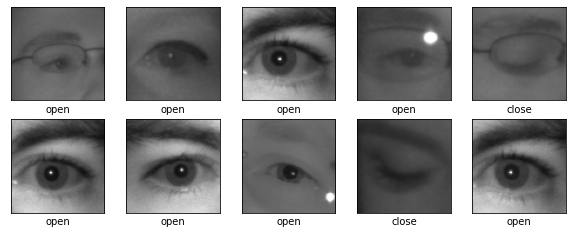

In [13]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

##7.Implementing the solution

###7.1 Baseline model

In [14]:
#creating a function that returns a Keras model

def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model


```KerasClassifier```is a wrapper that allows us to access scikit learn methods such as  cross-validation, model selection, pipelining, and grid search abilities using a keras model .<br>
A GridSearch will be performed to find optimum values for hyperparameters.

In [15]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)

In [16]:
#GridSearch parameters
params_deep={
    "layout":['3x3','5x5','2*3x3'],
    "dense_neurons1":[64,128],
    'filters':[8,18,32],
    "dropout":[0.1,0.5,],
    "pooling":[None,1],
    "epochs":[10]}



#Instantiate GridSearchCV
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep,cv=3,scoring='average_precision')



_```EarlyStopping```_ method helps to prevent overfitting in neural network as it stops training when a monitored metric has stopped improving as it's not possible to know in advance how many epochs you need to train your model on, and running the model multiple times with varying number of epochs maybe helpful, but is a time-consuming process.

In [17]:
# Defining the EarlyStopping callback
early_stop=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=.05)

In [18]:
#Fit the model
#gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

In [19]:
#print(f'Best Accuracy is {gs_deep.best_score_} \n using {gs_deep.best_params_}')

The optimal parameters are:
* dense_neurons1: 128
*  dropout: 0.1
*  epochs: 10
* filters: 32
* layout: 3x3
* pooling: None

From this grid search we find the best layout to be 3x3 with 32 filters. This means we will have one convolution layers with a kernel size of (3,3) representing the height and width of the filter. We will perform other iterations on the same layout but with three layers of dense neurons and different hyperparameters.

In [20]:
#GridSearch 2 parameters
params_deep_two={
    "layout":['3x3'],
    "dense_neurons1":[64,128,256],
    "dense_neurons2":[256,512],
    "dense_neurons3":[256,512],
    'filters':[32],
    "dropout":[0.1,0.3],
    "pooling":[None,1],
    "epochs":[10]

}

#Instantiate GridSearchCV
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep_two,cv=3,scoring='average_precision')

In [21]:
# #Fitting the model
#gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

In [22]:
#print(f'Best Accuracy for {gs_deep.best_score_} \n using {gs_deep.best_params_}')

The optimal parameters are :
* dense_neurons1: 256
* dense_neurons2 : 512
* dense_neurons3 : 512
* dropout : 0.1
* epochs : 10
* filters : 32  
* layout: 3x3
* pooling : None<br>

Given that we have an accuracy of 0.998397543919476, which is better than the neural network architecture with one dense layer at 0.999687577741359  , we can take these as the parameters to build our final model.

### 7.2 Final model


In [23]:
model=Sequential()

#adding first convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))

model.add(Flatten())

#adding first dense layer with 256 nodes
model.add(Dense(128, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.1))


#Output layer
model.add(Dense(1, activation='sigmoid'))
#compiling 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])



Best Accuracy is 0.9996987461792816 
 using {'dense_neurons1': 128, 'dropout': 0.1, 'epochs': 10, 'filters': 32, 'layout': '3x3', 'pooling': None}


In [24]:
#fitting on train data
history1 = model.fit(X_train,y_train,batch_size=200, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
15/15 [==============================] - 14s 68ms/step - loss: 6.1993 - auc: 0.5582 - val_loss: 1.8528 - val_auc: 0.7046
Epoch 2/10
15/15 [==============================] - 1s 40ms/step - loss: 0.6327 - auc: 0.8384 - val_loss: 0.2565 - val_auc: 0.9659
Epoch 3/10
15/15 [==============================] - 1s 39ms/step - loss: 0.3038 - auc: 0.9411 - val_loss: 0.2223 - val_auc: 0.9787
Epoch 4/10
15/15 [==============================] - 1s 39ms/step - loss: 0.2339 - auc: 0.9684 - val_loss: 0.1705 - val_auc: 0.9860
Epoch 5/10
15/15 [==============================] - 1s 39ms/step - loss: 0.1800 - auc: 0.9787 - val_loss: 0.1286 - val_auc: 0.9909
Epoch 6/10
15/15 [==============================] - 1s 40ms/step - loss: 0.1366 - auc: 0.9871 - val_loss: 0.0987 - val_auc: 0.9936
Epoch 7/10
15/15 [==============================] - 1s 39ms/step - loss: 0.1022 - auc: 0.9938 - val_loss: 0.0811 - val_auc: 0.9957
Epoch 8/10
15/15 [==============================] - 1s 39ms/step - loss: 0.0848 - 

In [25]:
#Inspecting the shape of our model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (200, 80, 80, 32)         896       
                                                                 
 flatten (Flatten)           (200, 204800)             0         
                                                                 
 dense (Dense)               (200, 128)                26214528  
                                                                 
 dropout (Dropout)           (200, 128)                0         
                                                                 
 dense_1 (Dense)             (200, 1)                  129       
                                                                 
Total params: 26,215,553
Trainable params: 26,215,553
Non-trainable params: 0
_________________________________________________________________


#### 7.2.1 Final Model evaluation

In [26]:
def evaluate(model):
  results_train = model.evaluate(X_train, y_train)
  print(f'Training Loss: {results_train[0]} \nTraining auc score: {results_train[1]}')

  print('----------')

  results_test =model.evaluate(X_test, y_test)
  print(f'Test Loss: {results_test[0]} \nTest auc score: {results_test[1]}')




evaluate(model) 

94/94 [==============================] - 1s 6ms/step - loss: 0.0530 - auc: 0.9990
Training Loss: 0.052960559725761414 
Training auc score: 0.9989708662033081
----------
32/32 [==============================] - 0s 7ms/step - loss: 0.0478 - auc: 0.9986
Test Loss: 0.04783238470554352 
Test auc score: 0.9985721707344055


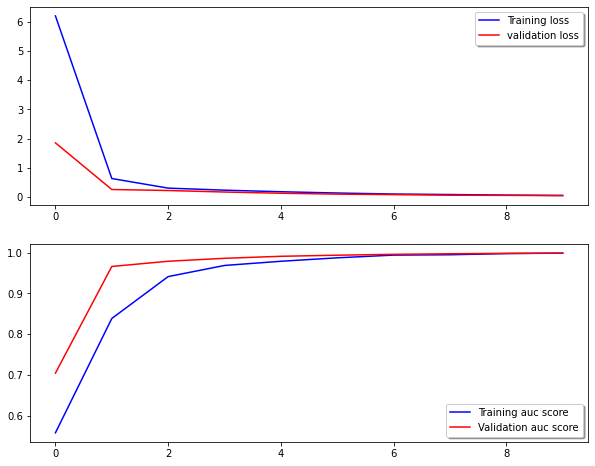

In [28]:
# Plot the loss and auc curves for training and validation 
def evaluation_visual(model,auc,val_auc):
  fig, ax = plt.subplots(2,1,figsize=(10,8))
  ax[0].plot(model.history['loss'], color='b', label="Training loss")
  ax[0].plot(model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)
 
  ax[1].plot(model.history[auc], color='b', label="Training auc score")
  ax[1].plot(model.history[val_auc], color='r',label="Validation auc score")
  legend = ax[1].legend(loc='best', shadow=True)




evaluation_visual(history1,'auc','val_auc')


In [27]:
export_model=Sequential()


#adding first convolution layer
export_model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))

export_model.add(Flatten())

#adding first dense layer with 256 nodes
export_model.add(Dense(128, activation='relu'))
#adding a dropout layer to avoid overfitting
export_model.add(Dropout(0.1))





#Output layer
export_model.add(Dense(1, activation='sigmoid'))
#compiling 
export_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])


In [29]:
export_model.fit(X_train,y_train,batch_size=200, epochs=10)

Epoch 1/10
15/15 [==============================] - 1s 38ms/step - loss: 4.1011 - auc_1: 0.6026
Epoch 2/10
15/15 [==============================] - 0s 33ms/step - loss: 0.4641 - auc_1: 0.8728
Epoch 3/10
15/15 [==============================] - 1s 33ms/step - loss: 0.3051 - auc_1: 0.9496
Epoch 4/10
15/15 [==============================] - 1s 33ms/step - loss: 0.1898 - auc_1: 0.9798
Epoch 5/10
15/15 [==============================] - 0s 33ms/step - loss: 0.1159 - auc_1: 0.9926
Epoch 6/10
15/15 [==============================] - 0s 33ms/step - loss: 0.0866 - auc_1: 0.9954
Epoch 7/10
15/15 [==============================] - 1s 34ms/step - loss: 0.0686 - auc_1: 0.9972
Epoch 8/10
15/15 [==============================] - 1s 34ms/step - loss: 0.0572 - auc_1: 0.9981
Epoch 9/10
15/15 [==============================] - 1s 34ms/step - loss: 0.0434 - auc_1: 0.9991
Epoch 10/10
15/15 [==============================] - 0s 33ms/step - loss: 0.0423 - auc_1: 0.9989


Saving the model

In [30]:
export_model.save("/content/drive/MyDrive/final_model.h5")

In [31]:
preds=model.predict(X_test)




Confusion matrix can be very helpfull to see your model drawbacks.

In [32]:
confusion_matrix=tf.math.confusion_matrix(labels=y_test,predictions=preds.round()).numpy()

confusion_matrix

array([[503,   7],
       [  5, 485]], dtype=int32)

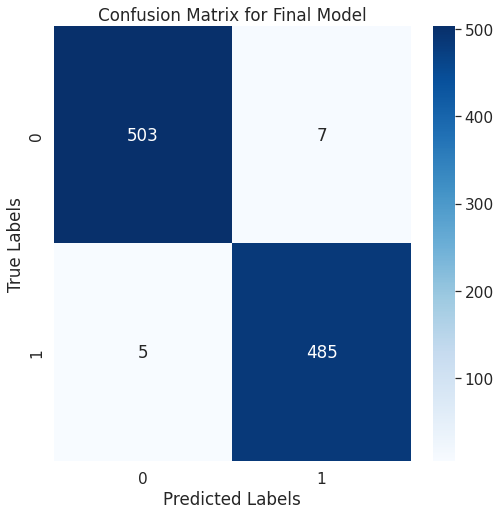

In [33]:
figure =plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix,cmap=plt.cm.Blues,annot=True,fmt="g")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Final Model')
plt.show()

In [34]:
tn, fp, fn, tp =confusion_matrix.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1_score = ((precision*recall)/(precision+recall))*2
print(f'Precision score is:',precision)
print(f'Recall score is:',recall)
print(f'Accuracy score is:',accuracy)
print(f'F1 score is:',f1_score)

Precision score is: 0.9857723577235772
Recall score is: 0.9897959183673469
Accuracy score is: 0.988
F1 score is: 0.9877800407331976


##8. Challenging the model
For this section, a transfer learning model will be used.Transfer learning for image classification is about leveraging feature representations from a pre-trained model, so you don't have to train a new model from scratch. The pre-trained models are usually trained on massive datasets that are a standard benchmark in the computer vision frontier.<br>

More spefically in this project will use VGG19, which is an advanced network with pretrained layers and a better understanding of what defines an image in terms of shape, color, and structure. VGG19 is very deep and has been trained on millions of diverse images with complex classification tasks.

VGG19 consists of 19 layers:

* 16 convolution layers
  * 5 MaxPool layers
  * 1 SoftMax layer
* 3 fully connected layers


In [35]:
vgg19_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(80, 80, 3))

80150528/80134624 [==============================] - 0s 0us/step


In [36]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [37]:
#Add the pretrained model as the first layer and adding dense layers
vgg_model =Sequential()
vgg_model.add(vgg19_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(132, activation='relu'))
vgg_model.add(layers.Dense(1, activation='sigmoid'))

###Freezing layers
 This means that all of the weights associated with that layer(s) will remain unchanged through the optimization process. Freezing the base is important as you wish to preserve the features encoded in this CNN base. Without this, the volatile gradients will quickly erase the useful features of the pretrained model.

In [38]:
# Checking whether a layer is trainable
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
    
# Checking how many trainable weights are in the model
print(len(vgg_model.trainable_weights))

vgg19 True
flatten_2 True
dense_4 True
dense_5 True
36


In [39]:
# freezing the layers
vgg19_model.trainable=False

In [40]:
#Confirming the base model is frozen
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
print(len(vgg_model.trainable_weights))


vgg19 False
flatten_2 True
dense_4 True
dense_5 True
4


In [41]:
#compiling 
vgg_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

#fitting on train data
history2 = vgg_model.fit(X_train,y_train,batch_size=200, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
15/15 [==============================] - 7s 264ms/step - loss: 0.4475 - auc_2: 0.8810 - val_loss: 0.3414 - val_auc_2: 0.9547
Epoch 2/10
15/15 [==============================] - 3s 235ms/step - loss: 0.3169 - auc_2: 0.9691 - val_loss: 0.2755 - val_auc_2: 0.9823
Epoch 3/10
15/15 [==============================] - 4s 238ms/step - loss: 0.2510 - auc_2: 0.9836 - val_loss: 0.2175 - val_auc_2: 0.9885
Epoch 4/10
15/15 [==============================] - 4s 239ms/step - loss: 0.2106 - auc_2: 0.9839 - val_loss: 0.1799 - val_auc_2: 0.9920
Epoch 5/10
15/15 [==============================] - 4s 242ms/step - loss: 0.1743 - auc_2: 0.9900 - val_loss: 0.1589 - val_auc_2: 0.9948
Epoch 6/10
15/15 [==============================] - 4s 243ms/step - loss: 0.1555 - auc_2: 0.9907 - val_loss: 0.1463 - val_auc_2: 0.9973
Epoch 7/10
15/15 [==============================] - 4s 250ms/step - loss: 0.1347 - auc_2: 0.9941 - val_loss: 0.1225 - val_auc_2: 0.9981
Epoch 8/10
15/15 [==============================

In [42]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 132)               270468    
                                                                 
 dense_5 (Dense)             (None, 1)                 133       
                                                                 
Total params: 20,294,985
Trainable params: 270,601
Non-trainable params: 20,024,384
_________________________________________________________________


In [43]:
evaluate(vgg_model)

94/94 [==============================] - 5s 40ms/step - loss: 0.0901 - auc_2: 0.9991
Training Loss: 0.09013853967189789 
Training auc score: 0.9990838766098022
----------
32/32 [==============================] - 1s 45ms/step - loss: 0.0859 - auc_2: 0.9994
Test Loss: 0.08594292402267456 
Test auc score: 0.9994001388549805


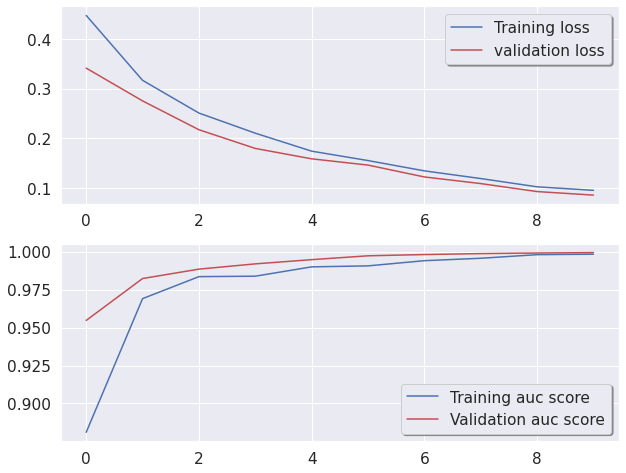

In [45]:
evaluation_visual(history2,'auc_2','val_auc_2')